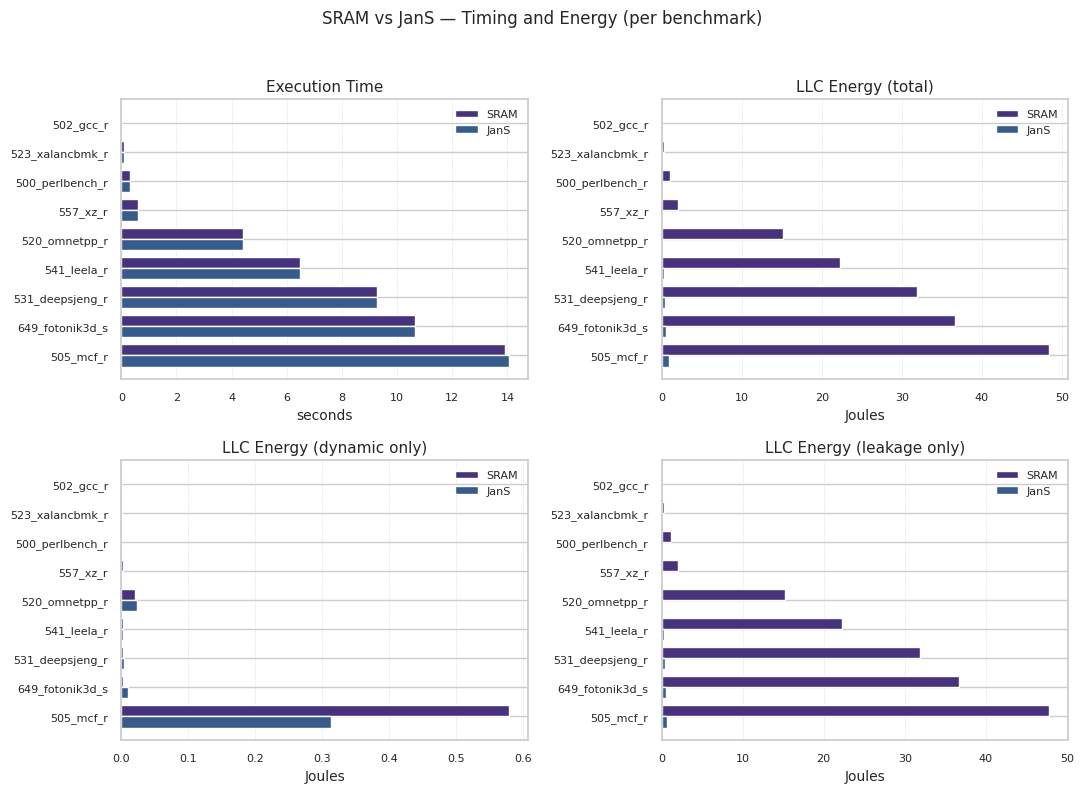

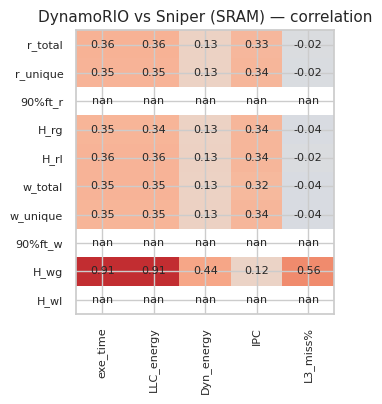

In [8]:
#!/usr/bin/env python3

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Absolute paths (edit if needed)
# -----------------------------
SNIPER_RESULTS_DIR = "/home/skataoka26/COSC_498/miniMXE/results/sniper_roi1000_fixedcap2m_20250927T171235Z"
DYNAMORIO_LOGS_DIR = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX   = "20250927T171235Z"  # prefix used in DynamoRIO filenames


# -----------------------------
# Parsing helpers
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    """
    energy_rows = []
    summary_rows = []

    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path  = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")

            e = pd.read_csv(energy_path)
            s = pd.read_csv(summary_path)

            # Keep columns we actually use
            e = e[[
                "benchmark", "config", "time_s",
                "energy_exact_J", "leak_J", "dyn_exact_nJ"
            ]].copy()
            s = s[[
                "benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"
            ]].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                e[col] = pd.to_numeric(e[col], errors="coerce")
            for col in ["ipc", "time_ns", "l3_miss_rate_pct"]:
                s[col] = pd.to_numeric(s[col], errors="coerce")

            # Convert nJ -> J
            e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError("Could not find summary.csv and energy_bounds.csv in output_* directories under: " + base_dir)

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)

    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")

    # minimal sanity
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    return df


def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files: take the LAST stats-like line (contains 'scope=').
    File name format: {ts}_<benchmark>_instr.rwstats.log
    """
    rows = []
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(r"%s_(.+?)_instr\.rwstats\.log$" % re.escape(ts_prefix), fname)
        if not m:
            continue
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        last = None
        with open(fpath, "r", errors="ignore") as f:
            for line in f:
                t = line.strip()
                if "scope=" in t and "=" in t:
                    last = t

        if not last:
            continue

        stats = {"benchmark": benchmark}
        for k, v in re.findall(r"([A-Za-z0-9_]+)=([-\d.eE+]+|nan)", last):
            if v.lower() == "nan":
                stats[k] = math.nan
            else:
                try:
                    stats[k] = float(v)
                except Exception:
                    pass
        rows.append(stats)

    return pd.DataFrame(rows) if rows else pd.DataFrame()


# -----------------------------
# Plot helpers
# -----------------------------
def grouped_barh(ax, labels, a_values, b_values, a_label, b_label, title, x_label):
    y = np.arange(len(labels))
    h = 0.38
    ax.barh(y - h/2, a_values, height=h, label=a_label)
    ax.barh(y + h/2, b_values, height=h, label=b_label)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # top item at top
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=10)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.legend(fontsize=8, frameon=False)


def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90)
    ax.set_title(title, fontsize=11)
    # annotate
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    return im


# -----------------------------
# Main
# -----------------------------
def main():
    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Focus on benchmarks present in BOTH SRAM and JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    sram = sram.loc[common].copy()
    jans = jans.loc[common].copy()

    # Sort by SRAM execution time to keep labels readable
    order = sram.sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    # ---------------- Sniper comparisons (compact 2x2) ----------------
    plt.rcParams.update({
        "figure.figsize": (11, 8),
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    })
    fig, axs = plt.subplots(2, 2)

    # 1) Execution time (s)
    grouped_barh(
        axs[0, 0], labels,
        sram["time_s"].values, jans["time_s"].values,
        "SRAM", "JanS",
        "Execution Time", "seconds"
    )

    # 2) Total LLC energy (J)
    grouped_barh(
        axs[0, 1], labels,
        sram["energy_exact_J"].values, jans["energy_exact_J"].values,
        "SRAM", "JanS",
        "LLC Energy (total)", "Joules"
    )

    # 3) Dynamic LLC energy (J) — leakage dominates overall, so plot dynamic alone
    grouped_barh(
        axs[1, 0], labels,
        sram["dyn_exact_J"].values, jans["dyn_exact_J"].values,
        "SRAM", "JanS",
        "LLC Energy (dynamic only)", "Joules"
    )

    # 4) Leakage LLC energy (J) — energy breakdown
    grouped_barh(
        axs[1, 1], labels,
        sram["leak_J"].values, jans["leak_J"].values,
        "SRAM", "JanS",
        "LLC Energy (leakage only)", "Joules"
    )

    fig.suptitle("SRAM vs JanS — Timing and Energy (per benchmark)", fontsize=12, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # ---------------- Correlation: DynamoRIO features vs Sniper (SRAM only) ----------------
    if not dr.empty:
        # Map DynamoRIO stats to the feature names you showed:
        # r_total, r_unique, 90%ft_r, H_rg, H_rl, w_total, w_unique, 90%ft_w, H_wg, H_wl
        feat_map = {
            "r_total":   ["read_total"],
            "r_unique":  ["read_unique"],
            "90%ft_r":   ["read_footprint90L", "read_footprint90"],  # prefer *_L if present
            "H_rg":      ["read_entropy"],
            "H_rl":      ["read_local_entropy"],
            "w_total":   ["write_total"],
            "w_unique":  ["write_unique"],
            "90%ft_w":   ["write_footprint90L", "write_footprint90"],
            "H_wg":      ["write_entropy"],
            "H_wl":      ["write_local_entropy"],
        }

        # Build a features df with those columns (best-effort if some are missing)
        feats = pd.DataFrame({"benchmark": dr["benchmark"]})
        for out_name, candidates in feat_map.items():
            chosen = None
            for c in candidates:
                if c in dr.columns:
                    chosen = c
                    break
            if chosen is not None:
                feats[out_name] = pd.to_numeric(dr[chosen], errors="coerce")
            else:
                feats[out_name] = np.nan

        feats = feats.set_index("benchmark")

        # Sniper targets (SRAM)
        targets = sram[[
            "time_s",            # Exec Time
            "energy_exact_J",    # LLC Energy (total)
            "dyn_exact_J",       # Dynamic LLC Energy
            "ipc",               # IPC
            "l3_miss_rate_pct"   # L3 miss rate
        ]].copy()
        targets.columns = ["exe_time", "LLC_energy", "Dyn_energy", "IPC", "L3_miss%"]

        # Join on common benchmarks
        corr_df = feats.join(targets, how="inner")
        # Compute correlation matrix and extract submatrix: features vs sniper metrics
        feature_names = ["r_total", "r_unique", "90%ft_r", "H_rg", "H_rl",
                         "w_total", "w_unique", "90%ft_w", "H_wg", "H_wl"]
        sniper_cols = ["exe_time", "LLC_energy", "Dyn_energy", "IPC", "L3_miss%"]

        # Drop columns that ended up all-NaN to avoid empty correlations
        feature_names = [f for f in feature_names if f in corr_df.columns and not corr_df[f].isna().all()]
        sniper_cols   = [c for c in sniper_cols   if c in corr_df.columns and not corr_df[c].isna().all()]

        if feature_names and sniper_cols and len(corr_df) >= 2:
            C = corr_df[feature_names + sniper_cols].corr().loc[feature_names, sniper_cols].values

            plt.figure(figsize=(3.6, max(2.8, 0.36 * len(feature_names) + 0.6)))
            ax = plt.gca()
            im = corr_heatmap(ax, C, feature_names, sniper_cols, "DynamoRIO vs Sniper (SRAM) — correlation")
            plt.tight_layout()
        else:
            print("Not enough data for correlation heatmap (missing features/targets or too few benchmarks).")

    # Show all
    plt.show()


if __name__ == "__main__":
    main()


<Figure size 1000x800 with 0 Axes>

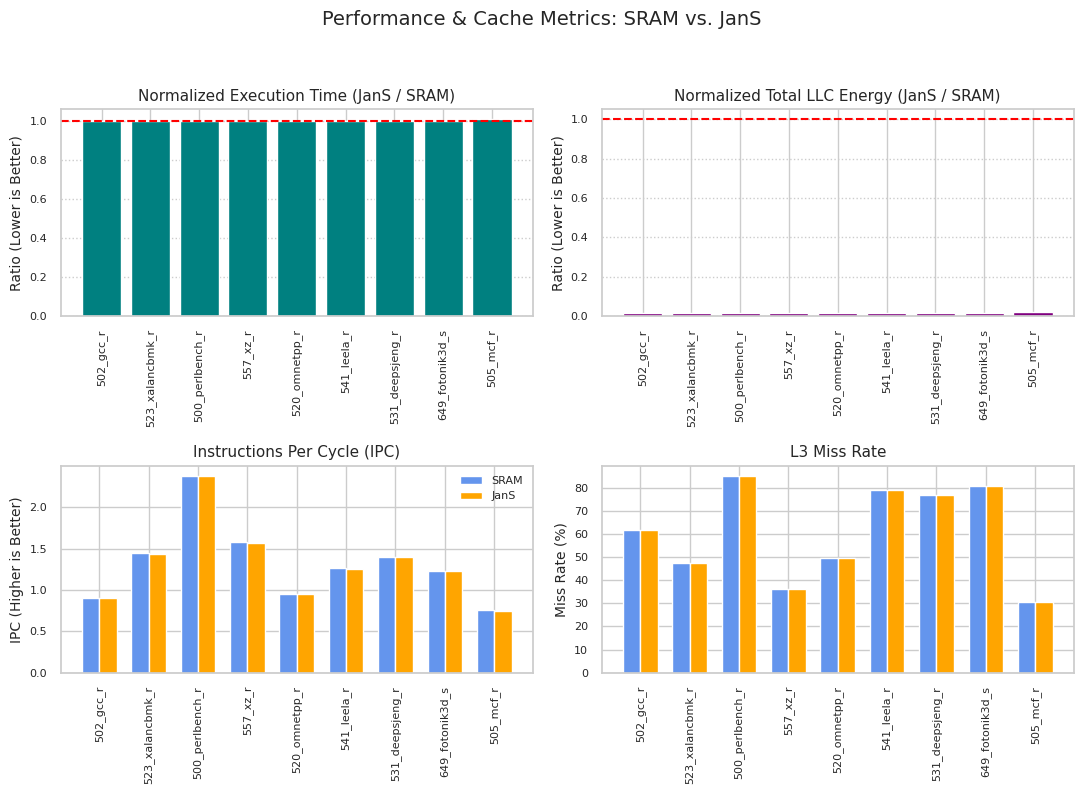

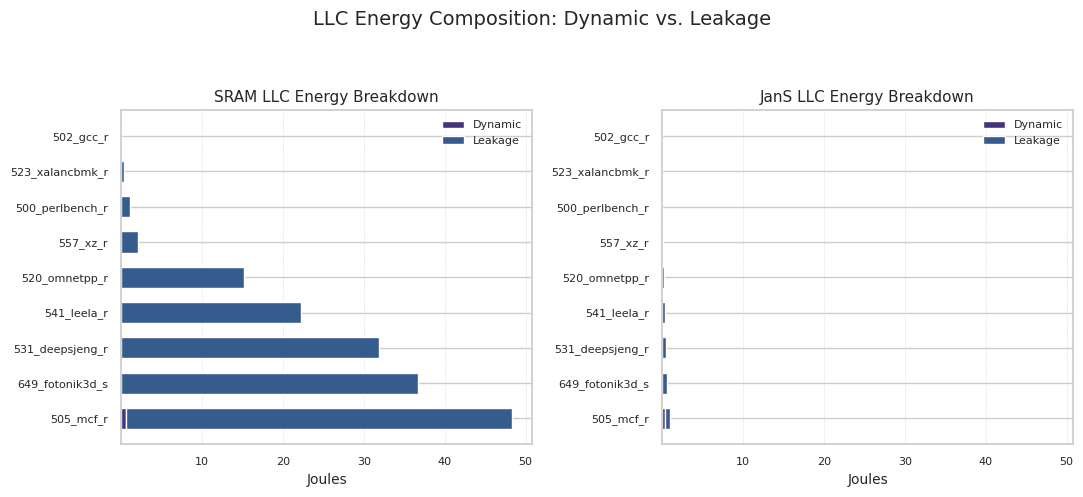

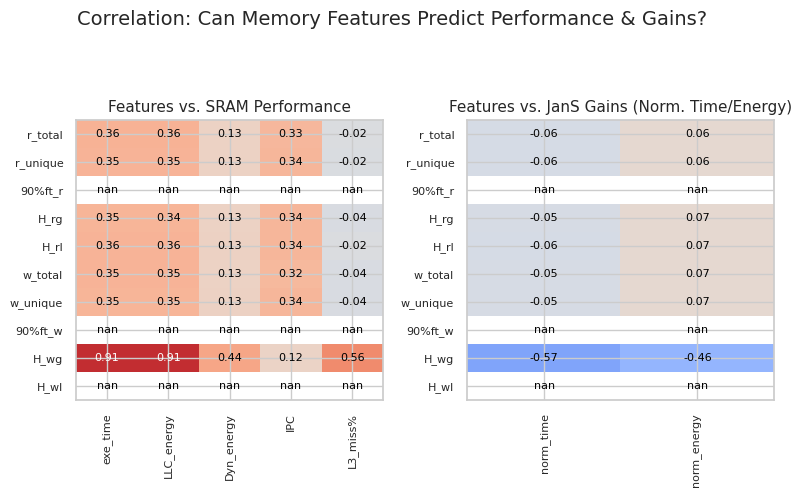

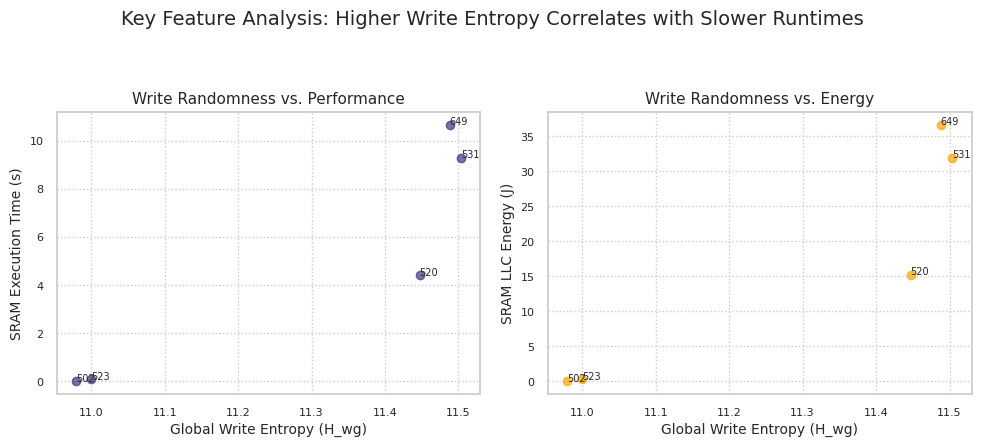

In [9]:
#!/usr/bin/env python3

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Absolute paths (edit if needed)
# -----------------------------
SNIPER_RESULTS_DIR = "/home/skataoka26/COSC_498/miniMXE/results/sniper_roi1000_fixedcap2m_20250927T171235Z"
DYNAMORIO_LOGS_DIR = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX    = "20250927T171235Z"  # prefix used in DynamoRIO filenames


# -----------------------------
# Parsing helpers
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    """
    energy_rows = []
    summary_rows = []

    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path  = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")

            e = pd.read_csv(energy_path)
            s = pd.read_csv(summary_path)

            # Keep columns we actually use
            e = e[[
                "benchmark", "config", "time_s",
                "energy_exact_J", "leak_J", "dyn_exact_nJ"
            ]].copy()
            s = s[[
                "benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"
            ]].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                e[col] = pd.to_numeric(e[col], errors="coerce")
            for col in ["ipc", "time_ns", "l3_miss_rate_pct"]:
                s[col] = pd.to_numeric(s[col], errors="coerce")

            # Convert nJ -> J
            e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError("Could not find summary.csv and energy_bounds.csv in output_* directories under: " + base_dir)

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)

    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")

    # minimal sanity
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    return df


def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files: take the LAST stats-like line (contains 'scope=').
    File name format: {ts}_<benchmark>_instr.rwstats.log
    """
    rows = []
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(r"%s_(.+?)_instr\.rwstats\.log$" % re.escape(ts_prefix), fname)
        if not m:
            continue
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        last = None
        with open(fpath, "r", errors="ignore") as f:
            for line in f:
                t = line.strip()
                if "scope=" in t and "=" in t:
                    last = t

        if not last:
            continue

        stats = {"benchmark": benchmark}
        for k, v in re.findall(r"([A-Za-z0-9_]+)=([-\d.eE+]+|nan)", last):
            if v.lower() == "nan":
                stats[k] = math.nan
            else:
                try:
                    stats[k] = float(v)
                except Exception:
                    pass
        rows.append(stats)

    return pd.DataFrame(rows) if rows else pd.DataFrame()


# -----------------------------
# Plot helpers
# -----------------------------
def grouped_barh(ax, labels, a_values, b_values, a_label, b_label, title, x_label):
    y = np.arange(len(labels))
    h = 0.38
    ax.barh(y - h/2, a_values, height=h, label=a_label)
    ax.barh(y + h/2, b_values, height=h, label=b_label)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # top item at top
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=10)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.legend(fontsize=8, frameon=False)


def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90)
    ax.set_title(title, fontsize=11)
    # annotate
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="white" if abs(val) > 0.6 else "black", fontsize=8)
    return im

def stacked_barh(ax, labels, data, category_labels, title, x_label):
    y = np.arange(len(labels))
    left = np.zeros(len(labels))
    for i, category in enumerate(data.keys()):
        values = data[category]
        ax.barh(y, values, left=left, label=category_labels[i], height=0.6)
        left += values
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.grid(True, axis="x", linestyle=":", linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x_label, fontsize=10)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.legend(fontsize=8, frameon=False)

# -----------------------------
# Main
# -----------------------------
def main():
    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Focus on benchmarks present in BOTH SRAM and JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    sram = sram.loc[common].copy()
    jans = jans.loc[common].copy()

    # Sort by SRAM execution time to keep labels readable
    order = sram.sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    # Calculate normalized metrics for new plots
    norm = pd.DataFrame(index=order)
    norm["norm_time"] = jans["time_s"] / sram["time_s"]
    norm["norm_energy"] = jans["energy_exact_J"] / sram["energy_exact_J"]

    # ------------------ Figure 1: Normalized Performance Summary ------------------
    plt.figure(figsize=(10, 8))
    fig, axs = plt.subplots(2, 2, figsize=(11, 8))

    # 1) Normalized Execution Time
    axs[0, 0].bar(norm.index, norm["norm_time"], color='teal')
    axs[0, 0].axhline(1.0, color='r', linestyle='--', linewidth=1.5)
    axs[0, 0].set_title("Normalized Execution Time (JanS / SRAM)", fontsize=11)
    axs[0, 0].set_ylabel("Ratio (Lower is Better)", fontsize=10)
    axs[0, 0].grid(True, axis="y", linestyle=":")
    
    # 2) Normalized Total LLC Energy
    axs[0, 1].bar(norm.index, norm["norm_energy"], color='purple')
    axs[0, 1].axhline(1.0, color='r', linestyle='--', linewidth=1.5)
    axs[0, 1].set_title("Normalized Total LLC Energy (JanS / SRAM)", fontsize=11)
    axs[0, 1].set_ylabel("Ratio (Lower is Better)", fontsize=10)
    axs[0, 1].grid(True, axis="y", linestyle=":")

    # 3) Absolute IPC
    x = np.arange(len(labels))
    width = 0.35
    axs[1, 0].bar(x - width/2, sram["ipc"], width, label='SRAM', color='cornflowerblue')
    axs[1, 0].bar(x + width/2, jans["ipc"], width, label='JanS', color='orange')
    axs[1, 0].set_title("Instructions Per Cycle (IPC)", fontsize=11)
    axs[1, 0].set_ylabel("IPC (Higher is Better)", fontsize=10)
    axs[1, 0].legend(fontsize=8, frameon=False)

    # 4) L3 Miss Rate
    axs[1, 1].bar(x - width/2, sram["l3_miss_rate_pct"], width, label='SRAM', color='cornflowerblue')
    axs[1, 1].bar(x + width/2, jans["l3_miss_rate_pct"], width, label='JanS', color='orange')
    axs[1, 1].set_title("L3 Miss Rate", fontsize=11)
    axs[1, 1].set_ylabel("Miss Rate (%)", fontsize=10)

    for ax in axs.flatten():
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.tick_params(axis="x", labelsize=8)

    fig.suptitle("Performance & Cache Metrics: SRAM vs. JanS", fontsize=14, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.96])


    # ------------------ Figure 2: LLC Energy Breakdown ------------------
    fig_e, axs_e = plt.subplots(1, 2, figsize=(11, 5), sharex=True)
    
    sram_energy_data = {'Dynamic': sram["dyn_exact_J"], 'Leakage': sram["leak_J"]}
    jans_energy_data = {'Dynamic': jans["dyn_exact_J"], 'Leakage': jans["leak_J"]}
    
    stacked_barh(axs_e[0], labels, sram_energy_data, ['Dynamic', 'Leakage'], "SRAM LLC Energy Breakdown", "Joules")
    stacked_barh(axs_e[1], labels, jans_energy_data, ['Dynamic', 'Leakage'], "JanS LLC Energy Breakdown", "Joules")

    fig_e.suptitle("LLC Energy Composition: Dynamic vs. Leakage", fontsize=14, y=0.99)
    fig_e.tight_layout(rect=[0, 0, 1, 0.94])


    # ------------------ Figure 3 & 4: Correlation Analysis ------------------
    if not dr.empty:
        feat_map = {
            "r_total":   ["read_total"], "r_unique":  ["read_unique"], "90%ft_r":   ["read_footprint90L", "read_footprint90"],
            "H_rg":      ["read_entropy"], "H_rl":      ["read_local_entropy"],
            "w_total":   ["write_total"], "w_unique":  ["write_unique"], "90%ft_w":   ["write_footprint90L", "write_footprint90"],
            "H_wg":      ["write_entropy"], "H_wl":      ["write_local_entropy"],
        }
        feats = pd.DataFrame({"benchmark": dr["benchmark"]})
        for out_name, candidates in feat_map.items():
            chosen = next((c for c in candidates if c in dr.columns), None)
            if chosen:
                feats[out_name] = pd.to_numeric(dr[chosen], errors="coerce")
            else:
                feats[out_name] = np.nan
        feats = feats.set_index("benchmark")

        targets_sram = sram[["time_s", "energy_exact_J", "dyn_exact_J", "ipc", "l3_miss_rate_pct"]].copy()
        targets_sram.columns = ["exe_time", "LLC_energy", "Dyn_energy", "IPC", "L3_miss%"]

        # Join features with both SRAM targets and normalized metrics
        corr_df = feats.join(targets_sram, how="inner").join(norm, how="inner")
        
        feature_names = [f for f in feat_map.keys() if f in corr_df.columns and not corr_df[f].isna().all()]
        sniper_cols = [c for c in targets_sram.columns if c in corr_df.columns and not corr_df[c].isna().all()]
        norm_cols = [c for c in norm.columns if c in corr_df.columns and not corr_df[c].isna().all()]

        if feature_names and (sniper_cols or norm_cols) and len(corr_df) >= 2:
            fig_c, axs_c = plt.subplots(1, 2, figsize=(8, 5))
            
            # Heatmap 1: Features vs SRAM Absolute Performance
            C1 = corr_df[feature_names + sniper_cols].corr().loc[feature_names, sniper_cols].values
            corr_heatmap(axs_c[0], C1, feature_names, sniper_cols, "Features vs. SRAM Performance")

            # Heatmap 2: Features vs Normalized Gains
            C2 = corr_df[feature_names + norm_cols].corr().loc[feature_names, norm_cols].values
            corr_heatmap(axs_c[1], C2, feature_names, norm_cols, "Features vs. JanS Gains (Norm. Time/Energy)")

            fig_c.suptitle("Correlation: Can Memory Features Predict Performance & Gains?", fontsize=14, y=0.99)
            fig_c.tight_layout(rect=[0, 0, 1, 0.92])

            # --- Figure 4: Scatter plot for the strongest correlation ---
            if 'H_wg' in corr_df.columns:
                fig_s, axs_s = plt.subplots(1, 2, figsize=(10, 4.5))
                
                # H_wg vs Execution Time
                ax = axs_s[0]
                ax.scatter(corr_df['H_wg'], corr_df['exe_time'], alpha=0.7)
                ax.set_xlabel("Global Write Entropy (H_wg)")
                ax.set_ylabel("SRAM Execution Time (s)")
                ax.set_title("Write Randomness vs. Performance")
                ax.grid(True, linestyle=":")
                for i, txt in enumerate(corr_df.index):
                     ax.annotate(txt.split('_')[0], (corr_df['H_wg'][i], corr_df['exe_time'][i]), fontsize=7)

                # H_wg vs LLC Energy
                ax = axs_s[1]
                ax.scatter(corr_df['H_wg'], corr_df['LLC_energy'], alpha=0.7, color='orange')
                ax.set_xlabel("Global Write Entropy (H_wg)")
                ax.set_ylabel("SRAM LLC Energy (J)")
                ax.set_title("Write Randomness vs. Energy")
                ax.grid(True, linestyle=":")
                for i, txt in enumerate(corr_df.index):
                     ax.annotate(txt.split('_')[0], (corr_df['H_wg'][i], corr_df['LLC_energy'][i]), fontsize=7)

                fig_s.suptitle("Key Feature Analysis: Higher Write Entropy Correlates with Slower Runtimes", fontsize=14, y=0.99)
                fig_s.tight_layout(rect=[0, 0, 1, 0.93])

    # Show all generated figures
    plt.show()


if __name__ == "__main__":
    main()

